# ResNet
随着我们设计越来越深的网络，深刻理解“新添加的层如何提升神经网络的性能”变得至关重要。更重要的是设计网络的能力，在这种网络中，添加层会使网络更具表现力， 为了取得质的突破，我们需要一些数学基础知识。

## 1、函数类
给定一个具有  X  特性和  y  标签的数据集，我们可以尝试通过解决以下优化问题来找到它：
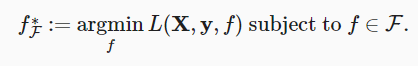

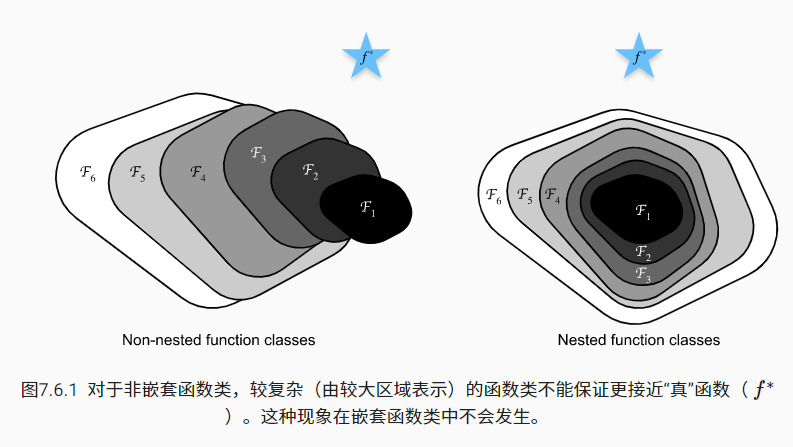

因此，只有当较复杂的函数类包含较小的函数类时，我们才能确保提高它们的性能。 对于深度神经网络，如果我们能将新添加的层训练成 恒等映射（identity function）  f(x)=x  ，新模型和原模型将同样有效。 同时，由于新模型可能得出更优的解来拟合训练数据集，因此添加层似乎更容易降低训练误差。

针对这一问题，何恺明等人提出了残差网络（ResNet）。残差网络的核心思想是：每个附加层都应该更容易地包含原始函数作为其元素之一。 于是，残差块 （residual blocks） 便诞生了，这个设计对如何建立深层神经网络产生了深远的影响。 

## 2、残差块： 
聚焦于神经网络局部：假设我们的原始输入为  x  ，而希望学出的理想映射为  f(x) 。左图虚线框中的部分需要直接拟合出该映射  f(x)  ，而右图虚线框中的部分则需要拟合出残差映射  f(x)−x  

残差映射在现实中往往更容易优化。 以本节开头提到的恒等映射作为我们希望学出的理想映射  f(x)  ，我们只需将 图7.6.2 中右图虚线框内上方的加权运算（如仿射）的权重和偏置参数设成 0，那么  f(x)  即为恒等映射。 实际中，当理想映射  f(x)  极接近于恒等映射时，残差映射也易于捕捉恒等映射的细微波动。

右图是 ResNet 的基础结构– 残差块（residual block）。 在残差块中，输入可通过跨层数据线路更快地向前传播。

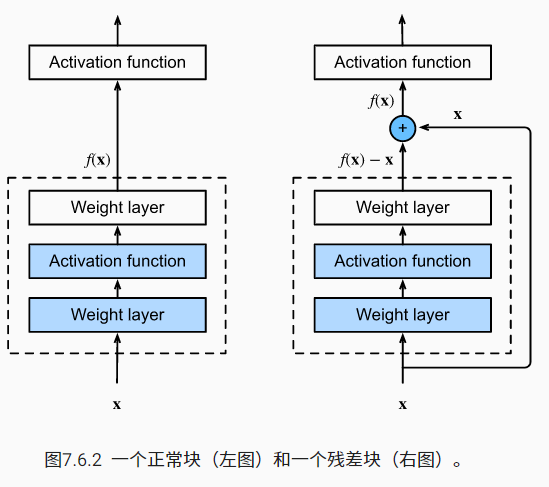

ResNet 沿用了 VGG 完整的  3×3  卷积层设计。 残差块里首先有 2 个有相同输出通道数的  3×3  卷积层。 每个卷积层后接一个批量归一化层和 ReLU 激活函数。

然后我们通过跨层数据通路，跳过这 2 个卷积运算，将输入直接加在最后的 ReLU 激活函数前。 

 这样的设计要求 2 个卷积层的输出与输入形状一样，从而可以相加。 如果想改变通道数，就需要引入一个额外的  1×1  卷积层来将输入变换成需要的形状后再做相加运算。 残差块的实现如下：

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import sys
sys.path.append('../../CommonFunctions/tools/')
import common_tools

In [2]:
class Residual(nn.Module): #@save
    def __init__(self, input_channels, num_channels, 
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, 
                               kernel_size=3, padding=1, 
                               stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, 
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, 
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [16]:
# 改进：在forward中加入条件判断语句，速度应该会下降？ 
# （猜测）因为GPU没有分支预测，也无法乱序执行。
# 建议放在__init__函数中根据条件先定义好模块，到forward中直接用。
class Build_block(nn.Module):
    def __init__(self,in_channels,out_channels,downsample=False):
        super().__init__()
        self.preprocess = nn.Sequential()
        if downsample: # 如果需要做下采样，说明通道和分辨率都需要改变
            self.conv1 = Basic_conv(in_channels,out_channels,stride = 2)
            conv3 = Basic_conv(in_channels,out_channels,stride = 2)
            self.preprocess.add_module('1x1conv',conv3) 
        else:
            self.conv1 = Basic_conv(in_channels,out_channels,stride = 1)

        self.conv2 = Basic_conv(out_channels,out_channels,stride = 1)
        self.relu = nn.ReLU()

    def forward(self,X):
        Y = self.conv1(X)
        Y = self.relu(Y)
        Y = self.conv2(Y)
        Y += self.preprocess(X)
        return Y

此代码生成两种类型的网络： 一种是在 use_1x1conv=False 、应用 ReLU 非线性函数之前，将输入添加到输出。 另一种是在 use_1x1conv=True 时，添加通过  1×1  卷积调整通道和分辨率。

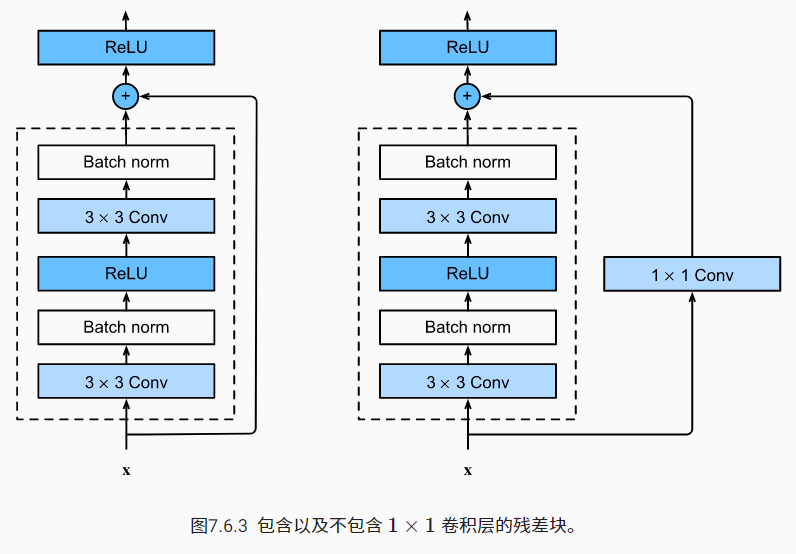

In [3]:
# 查看输入和输出形状一致的情况。
blk = Residual(3, 3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [4]:
# 也可以在增加输出通道数的同时，减半输出的高和宽。
blk = Residual(3, 6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

## 3、ResNet模型
ResNet 的前两层跟之前介绍的 GoogLeNet 中的一样： 在输出通道数为 64、步幅为 2 的  7×7  卷积层后，接步幅为 2 的  3×3  的最大池化层。 不同之处在于 ResNet 每个卷积层后增加了批量归一化层。

In [6]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), 
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

ResNet 则使用 4 个由残差块组成的模块，每个模块使用若干个同样输出通道数的残差块。 第一个模块的通道数同输入通道数一致。 由于之前已经使用了步幅为 2 的最大池化层，所以无须减小高和宽。 之后的每个模块在第一个残差块里将上一个模块的通道数翻倍，并将高和宽减半。

注意，我们对第一个模块做了特别处理。

In [7]:
def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        # 如果是模块的第一个残差块且不是第一个模块，通道数翻倍，宽高减半
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, 
                                num_channels, 
                                use_1x1conv=True, 
                                strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

接着在 ResNet 加入所有残差块，这里每个模块使用 2 个残差块。

In [8]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

最后，与 GoogLeNet 一样，在 ResNet 中加入全局平均池化层，以及全连接层输出。

In [11]:
net = nn.Sequential(b1, b2, b3, b4, b5, 
                    nn.AdaptiveAvgPool2d((1, 1)), 
                    nn.Flatten(), 
                    nn.Linear(512, 10))

每个模块有 4 个卷积层（不包括恒等映射的  1×1  卷积层）。 加上第一个  7×7  卷积层和最后一个全连接层，共有 18 层。 因此，这种模型通常被称为 ResNet-18。

通过配置不同的通道数和模块里的残差块数可以得到不同的 ResNet 模型，例如更深的含 152 层的 ResNet-152。 虽然 ResNet 的主体结构跟 GoogLeNet类似，但 ResNet 结构更简单，修改也更方便。这些因素都导致了 ResNet 迅速被广泛使用。
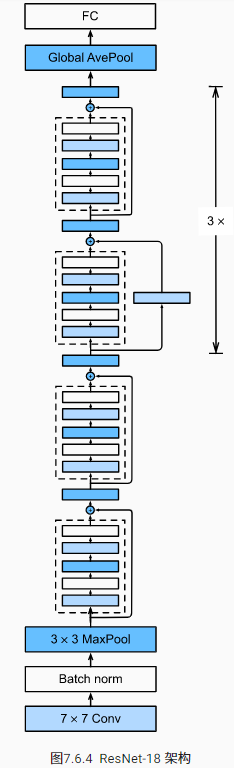

In [12]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


## 4、训练模型

loss 0.007, train acc 0.999, test acc 0.903
4902.7 examples/sec on cuda:2


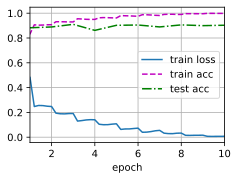

In [13]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = common_tools.load_data_fashion_mnist(batch_size, resize=96)
common_tools.train_ch6(net, train_iter, test_iter, num_epochs, lr, common_tools.try_gpu(2))